## Total Economy Productivity

In [3]:
# Import preliminaries
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('axes', edgecolor='lightgray')
plt.rc('ytick',labelsize=8)
plt.rc('xtick',labelsize=8)
import itertools, os
from pathlib import Path

# Seasonal Adjustment Tools
os.environ['X13PATH'] = '/home/brian/Documents/econ_data/micro/x13as/'
import statsmodels.api as sm
from statsmodels.tsa.x13 import x13_arima_analysis

# bd CPS files
cps_dir = Path('/home/brian/Documents/CPS/data/clean/')
data_dir = Path('/home/brian/Documents/uschartbook/chartbook/data/')

# Recession start and end months, from NBER
rec_dt = [('1969-12-01', '1970-11-01'), ('1973-11-01', '1975-03-01'), 
          ('1980-01-01', '1980-07-01'), ('1981-07-01', '1982-11-01'),
          ('1990-07-01', '1991-03-01'), ('2001-04-01', '2001-12-01'), 
          ('2008-01-01', '2009-07-01'), ('2020-02-01', '2020-04-01')]


# Function to retrieve a series from FRED
def fred_df(series):
    url = f'http://research.stlouisfed.org/fred2/series/{series}/downloaddata/{series}.csv'
    df = pd.read_csv(url, index_col='DATE', parse_dates=True, na_values=['.'])
    return df.rename({'VALUE': series}, axis=1)

### Collect Data

In [232]:
# GDP including latest Nowcast
gdp = fred_df('GDPC1')['GDPC1']
now = fred_df('GDPNOW')['GDPNOW']
nch = (((now.iloc[-1] / 100) + 1) ** (1/4))
gdp.loc[now.index[-1]] = gdp.iloc[-1] * nch

# CPS based hours worked index
lp = pd.read_csv(data_dir / 'gdpjobslvl_mo.csv', index_col='date', 
                  parse_dates=True)
lp = pd.concat([lp[['EPOP_sa', 'AAH_trend']].ffill(), lp['POP']], axis=1)
hrs = (res['EPOP_sa'] / 100) * (res['POP'] * 1_000_000) * (res['AAH_trend'] * 52)
idx = gdp.divide(hrs.resample('QS').last(), axis=0)
idx = idx / idx.loc['2018-01-01']

# LPC index
df = pd.read_csv(data_dir / 'lprod.csv', index_col='date', parse_dates=True)
lpc = df['value_index'] / df['value_index'].loc['2018-01-01']

# Combine Data
data = pd.concat([lpc, idx], axis=1).loc['2014':]

# Recent Growth Rates
samp = data.loc[:'2019-10-01']
deg = len(samp) - 1
qtrrt = (samp.iloc[-1] / samp.iloc[0]) ** (1/deg)
annrt = qtrrt ** 4

# Projections
vals = data.loc['2019-10-01']
proj_dates = data.loc['2019-10-10':].index
data.loc['2019-10-01', 'NFB_Proj'] = vals['value_index']
data.loc['2019-10-01', 'CPS_Proj'] = vals[0]
for i in proj_dates:
    pr_dt = i - pd.DateOffset(months=3)
    prnfb = data.loc[pr_dt, 'NFB_Proj']
    data.loc[i, 'NFB_Proj'] = prnfb * qtrrt['value_index']
    prcps = data.loc[pr_dt, 'CPS_Proj']
    data.loc[i, 'CPS_Proj'] = prcps * qtrrt[0]

### Create Chart

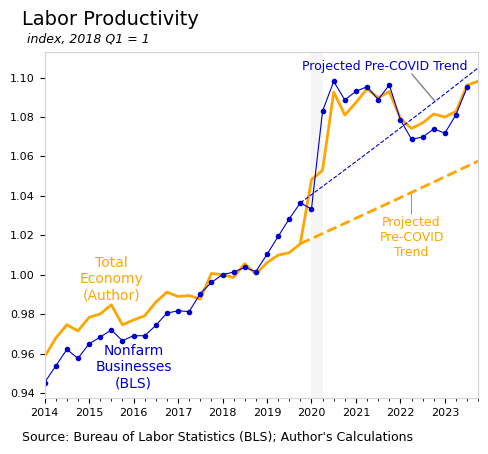

In [234]:
# Create Chart
fig, ax = plt.subplots(figsize=(5, 4))
plt.tight_layout()
colors = ['mediumblue', 'orange']
data[0].plot(ax=ax, color=colors[1], legend=False, lw=2)
data['value_index'].plot(ax=ax, color=colors[0], lw=0.8, 
                         legend=False, marker='.')
data['CPS_Proj'].plot(ax=ax, color=colors[1], 
                                    legend=False, ls='--', lw=2)
data['NFB_Proj'].plot(ax=ax, color=colors[0], 
                                    legend=False, ls='--', lw=0.8)

# Recession bars
for r_start, r_end in rec_dt:
    ax.axvspan(r_start, r_end, facecolor='whitesmoke', zorder=0)
    
# Annotations
tetxt = 'Total\nEconomy\n(Author)'
ax.text('2015-08-01', 0.986, tetxt, color=colors[1], size=10, 
        ha='center', va='bottom')
projcpstxt = 'Projected\nPre-COVID\nTrend'
ax.text('2022-06-01', 1.03, projcpstxt, color=colors[1], size=9, 
        ha='center', va='top')
plt.arrow('2022-05-01',1.042,0,-0.007, lw=0.3, color='gray')
nfbtxt = 'Nonfarm\nBusinesses\n(BLS)'
ax.text('2016-01-01', 0.965, nfbtxt, color=colors[0], size=10, 
        ha='center', va='top')
ax.text('2023-08-01', 1.109, 'Projected Pre-COVID Trend', color=colors[0], size=9, 
        ha='right', va='top') 
plt.arrow('2022-05-01',1.102,2.1,-0.014, lw=0.05, color='gray')
# Title and footer
fig.text(0.04, 1.02, 'Labor Productivity', size=14)
subtitle = ('index, 2018 Q1 = 1')
fig.text(0.05, 0.975, subtitle, size=9, style='italic')
footer = ("Source: Bureau of Labor Statistics (BLS); Author's Calculations")
fig.text(0.04, -0.02, footer, size=9)
plt.savefig('chart1.png', bbox_inches='tight')
plt.show()

In [243]:
# Long-term
full = pd.concat([lpc, idx], axis=1).dropna()
deg = len(full) - 1
qtrrt = (full.iloc[-1] / full.iloc[0]) ** (1/deg)
annrt = qtrrt ** 4
annrt

value_index    1.019462
0              1.015273
dtype: float64

In [247]:
# Since 2019
full = pd.concat([lpc, idx], axis=1).loc['2019-10-01':].dropna()
deg = len(full) - 1
qtrrt = (full.iloc[-1] / full.iloc[0]) ** (1/deg)
annrt = qtrrt ** 4
annrt

value_index    1.014776
0              1.020521
dtype: float64